In [1]:
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/MyDrive/Machine Learning Final Project/garbage_classification"

In [4]:
#80% for train and 20% for vali
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size = (224, 224),
  batch_size = 64)

ds_vali = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size = (224, 224),
  batch_size = 64)

Found 15518 files belonging to 12 classes.
Using 12415 files for training.
Found 15518 files belonging to 12 classes.
Using 3103 files for validation.


In [15]:
# Assuming ds_vali (from Q-k5NAspmiyU) is the full 20% validation split.
# We want to split this into a new ds_vali (10%) and ds_test (10%).

# Store the original full validation split before modifying ds_vali.
# This ensures both new ds_vali and ds_test are derived from the same source.
original_validation_split = ds_vali

# Calculate the number of batches for the new validation set (50% of the original validation split).
# len(dataset) returns the number of batches.
val_batches = int(len(original_validation_split) * 0.5)

# Assign the first half of the original validation split to the new ds_vali.
ds_vali = original_validation_split.take(val_batches)

# Assign the remaining half of the original validation split to ds_test.
ds_test = original_validation_split.skip(val_batches)

NameError: name 'vali_ds' is not defined

In [6]:
class_names = ds_train.class_names
print(class_names)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [7]:
#normaliza the pixel (0-1)
def normalize(image, label):
  image = image / 255.0
  return image, label

ds_train = ds_train.map(normalize)
ds_vali= ds_vali.map(normalize)
ds_test= ds_test.map(normalize)

In [8]:
for images, labels in ds_train.take(1):
    print("Pixel range:", images[0].numpy().min(), "to", images[0].numpy().max())

Pixel range: 0.0 to 1.0


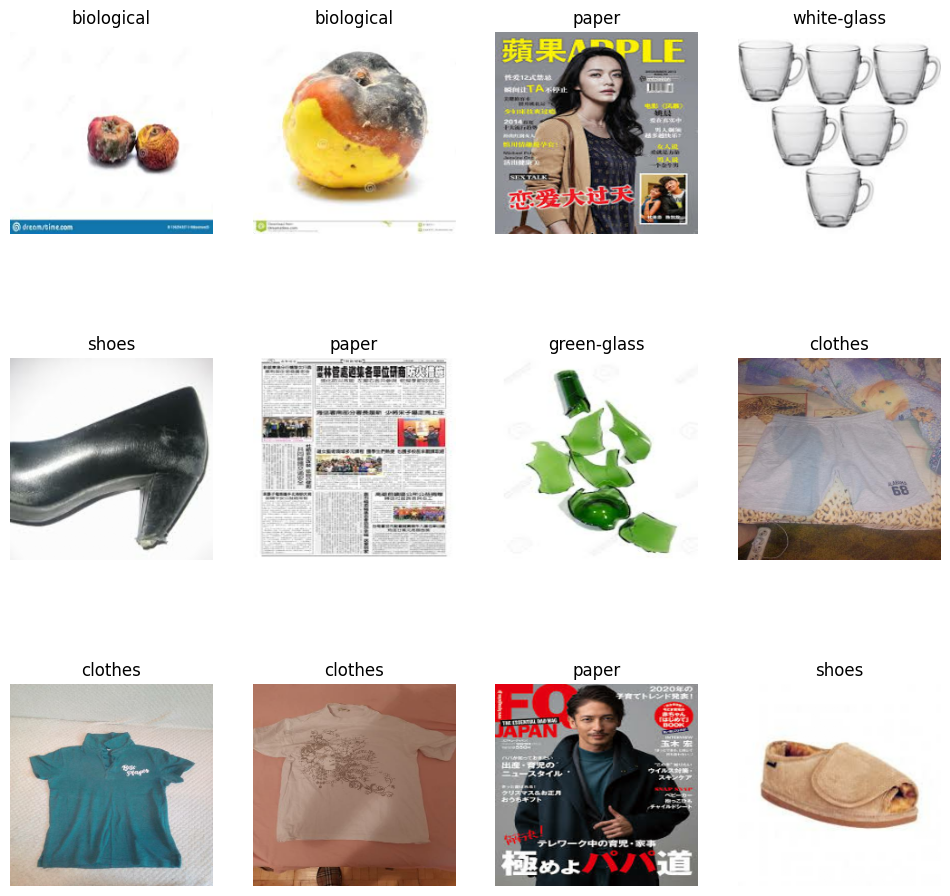

In [9]:
#display images
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))
for images, labels in ds_train.take(1):
    imgs = images[:12].numpy()
    lbls = labels[:12].numpy()

    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(np.clip(imgs[i], 0, 1))
        plt.title(class_names[int(lbls[i])])
        plt.axis("off")

plt.show()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

image_augment = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(height_factor=(-0.2, -0.3), interpolation = 'bilinear'),
        layers.RandomContrast(factor=0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name = "image_augmentation",
)

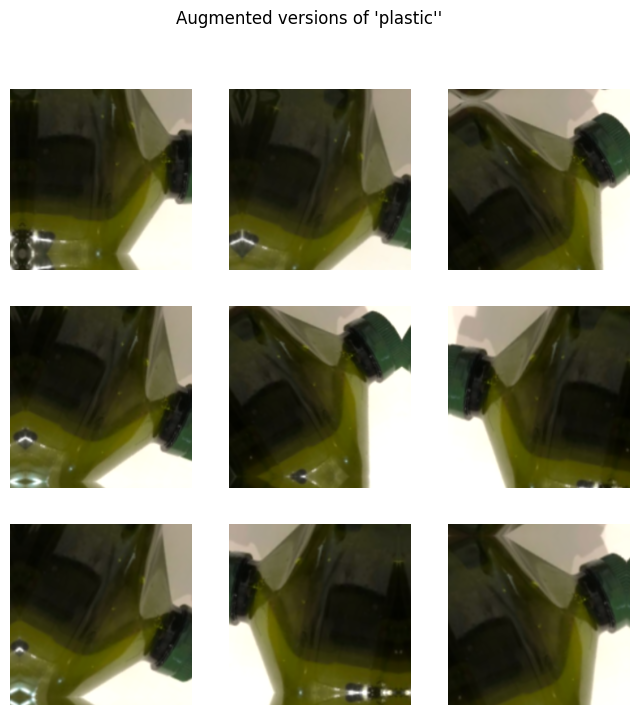

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

for images, labels in ds_train.take(1):
    plt.figure(figsize=(8, 8))
    first_image = images[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented = image_augment(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented[0].numpy())
        plt.axis("off")
    plt.suptitle(f"Augmented versions of '{class_names[int(labels[1])]}''")
plt.show()

In [12]:
#check balance
import os

class_names = sorted([d for d in os.listdir(dataset_path)
                      if os.path.isdir(os.path.join(dataset_path, d))])

counts = {c: len(os.listdir(os.path.join(dataset_path, c))) for c in class_names}
total = sum(counts.values())
n_classes = len(class_names)
print(f"Counts per class:", counts)

Counts per class: {'battery': 945, 'biological': 985, 'brown-glass': 607, 'cardboard': 891, 'clothes': 5327, 'green-glass': 629, 'metal': 769, 'paper': 1050, 'plastic': 865, 'shoes': 1978, 'trash': 697, 'white-glass': 775}


In [13]:
#add class_weight
#formula: weight_i = total / (n_classes * count_i)
counts = {c: len(os.listdir(os.path.join(dataset_path, c))) for c in class_names}
total = sum(counts.values())
n_classes = len(class_names)

class_index = {c:i for i,c in enumerate(class_names)}
class_weight = {class_index[c]: total/(n_classes*counts[c]) for c in class_names}

print(class_weight)


{0: 1.3684303350970017, 1: 1.3128595600676818, 2: 2.130422844590884, 3: 1.4513655069210625, 4: 0.24275702396595958, 5: 2.0559088500264973, 6: 1.6816211530125704, 7: 1.2315873015873016, 8: 1.494990366088632, 9: 0.6537748567576677, 10: 1.8553323768531802, 11: 1.6686021505376345}


In [14]:
#do this to keep CPU not to idle when its loading a new process
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_vali  = ds_vali.cache().prefetch(buffer_size=AUTOTUNE)
ds_test  = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# #save the preprocessing
import json

save_dir = "/content/drive/MyDrive/Machine Learning Final Project/preprocessed_data"
os.makedirs(save_dir, exist_ok=True)

# #datasets
# ds_train.save(os.path.join(save_dir, "train_dataset"))
# ds_vali.save(os.path.join(save_dir, "validate_dataset"))
# ds_test.save(os.path.join(save_dir, "test_dataset"))

In [18]:
#metadata
with open(os.path.join(save_dir, "class_names.json"), "w") as f:
    json.dump(class_names, f, indent=2)

with open(os.path.join(save_dir, "class_weights.json"), "w") as f:
    json.dump(class_weight, f, indent=2)

# **Training Model**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import json
import os
import matplotlib.pyplot as plt

In [4]:
train_path = "/content/drive/MyDrive/Machine Learning Final Project/preprocessed_data/train_dataset"
val_path = "/content/drive/MyDrive/Machine Learning Final Project/preprocessed_data/validate_dataset"
test_path = "/content/drive/MyDrive/Machine Learning Final Project/preprocessed_data/test_dataset"

train_ds = tf.data.Dataset.load(train_path)
val_ds = tf.data.Dataset.load(val_path)
test_ds = tf.data.Dataset.load(test_path)

print("Datasets loaded successfully")

Datasets loaded successfully


In [5]:
with open("/content/drive/MyDrive/Machine Learning Final Project/preprocessed_data/class_names.json") as f:
    class_names = json.load(f)

with open("/content/drive/MyDrive/Machine Learning Final Project/preprocessed_data/class_weights.json") as f:
    class_weights = json.load(f)
    class_weights = {int(k): float(v) for k, v in class_weights.items()}  # Convert keys to int

n_classes = len(class_names)
print("Classes:", class_names)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [6]:
# Use MobileNetV2 as base model — good balance of speed and accuracy
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,   # Remove original classification layers
    weights='imagenet'   # Start from pretrained weights
)

base_model.trainable = False  # Freeze the base model for initial training

# Build the final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights
)

Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 170s 876ms/step - accuracy: 0.3819 - loss: 2.1761 - val_accuracy: 0.8424 - val_loss: 0.6765
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - accuracy: 0.8299 - loss: 0.8627 - val_accuracy: 0.8802 - val_loss: 0.4278
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - accuracy: 0.8804 - loss: 0.5714 - val_accuracy: 0.8976 - val_loss: 0.3540
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 50s 295ms/step - accuracy: 0.8977 - loss: 0.4595 - val_accuracy: 0.9045 - val_loss: 0.3185
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 49s 287ms/step - accuracy: 0.9065 - loss: 0.3980 - val_accuracy: 0.9123 - val_loss: 0.2971
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.9154 - loss: 0.3481 - val_accuracy: 0.9145 - val_loss: 0.2783
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 48s 282ms/step - accuracy: 0.9267 - loss: 0.3218 - val_accuracy: 0.9219 - val_loss: 0.2663
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 50s 295ms/step - accuracy: 0.9338 - loss: 

In [9]:
# Unfreeze some top layers of base_model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # fine-tune last 30
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    class_weight=class_weights
)


Epoch 20/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 78s 357ms/step - accuracy: 0.8695 - loss: 0.5183 - val_accuracy: 0.9206 - val_loss: 0.2524
Epoch 21/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.9304 - loss: 0.2464 - val_accuracy: 0.9297 - val_loss: 0.2358
Epoch 22/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 49s 283ms/step - accuracy: 0.9455 - loss: 0.1922 - val_accuracy: 0.9314 - val_loss: 0.2282
Epoch 23/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - accuracy: 0.9534 - loss: 0.1554 - val_accuracy: 0.9327 - val_loss: 0.2230
Epoch 24/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 50s 290ms/step - accuracy: 0.9630 - loss: 0.1285 - val_accuracy: 0.9362 - val_loss: 0.2152
Epoch 25/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 291ms/step - accuracy: 0.9716 - loss: 0.1074 - val_accuracy: 0.9366 - val_loss: 0.2083
Epoch 26/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 50s 290ms/step - accuracy: 0.9753 - loss: 0.0918 - val_accuracy: 0.9401 - val_loss: 0.2039
Epoch 27/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 49s 287ms/step - accuracy: 0.9786 -

In [16]:
test_loss, test_acc = model.evaluate(val_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9483 - loss: 0.1714

Test Accuracy: 0.9440
Test Loss: 0.1934


In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

if 'accuracy' in history_fine.history:
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

# Create test accuracy/loss lists same length as epochs
epochs = len(acc)
test_acc_curve = [test_acc] * epochs
test_loss_curve = [test_loss] * epochs

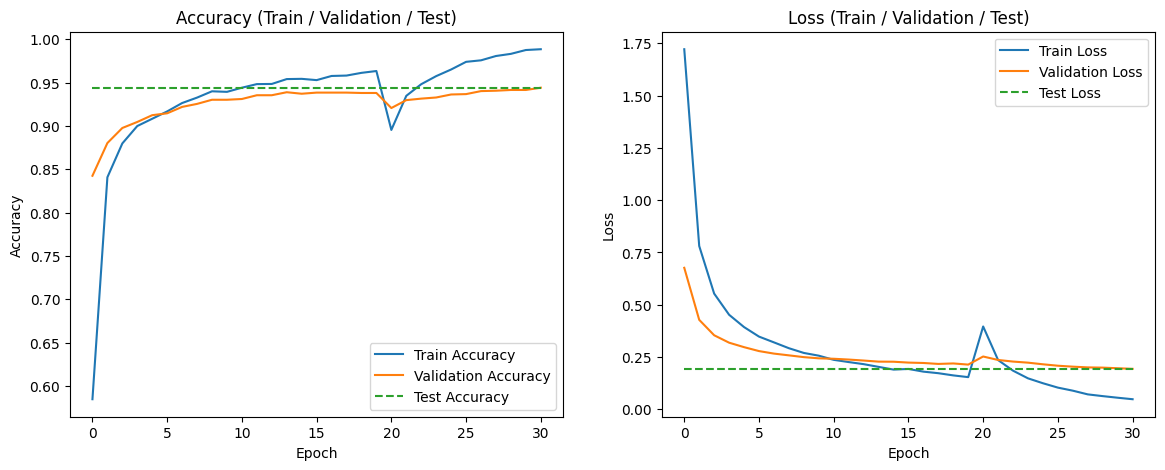

In [18]:
# visualize Training Results

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(test_acc_curve, label='Test Accuracy', linestyle='--')
plt.title('Accuracy (Train / Validation / Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot(test_loss_curve, label='Test Loss', linestyle='--')
plt.title('Loss (Train / Validation / Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
save_model_path = "/content/drive/MyDrive/Machine Learning Final Project/mobilenet_model.keras"
os.makedirs(os.path.dirname(save_model_path), exist_ok=True)
model.save(save_model_path)
print(f"Model saved successfully at: {save_model_path}")

Model saved successfully at: /content/drive/MyDrive/Machine Learning Final Project/mobilenet_model.keras
